In [1]:
import random
import numpy as np
import random
import gym
from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML, clear_output
import time

In [2]:
#Setting up the environment
env = gym.make('Taxi-v3')

env.reset()

#Current State
print(env.s)

# 5x5x5x4 grid = 500 states
print ("Number of states:", env.nS)

# Primitive Actions
action = ["south", "north", "east", "west","pick","drop"]
#correspond to [0,1,2,3,4,5] that's actually passed to the environment

# either go left, up, down or right
print ("Number of actions that an agent can take:", env.nA)

# Example Transitions
rnd_action = random.randint(0, 3)
print ("Action taken:", action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("Transition probability:", t_prob)
print ("Next state:", next_state)
print ("Reward recieved:", reward)
print ("Terminal state:", is_terminal)

state = env.reset()
print ("Decoded state:", list(env.decode(state)))
env.render()

382
Number of states: 500
Number of actions that an agent can take: 6
Action taken: west
Transition probability: {'prob': 1.0}
Next state: 362
Reward recieved: -1
Terminal state: False
Decoded state: [3, 0, 3, 1]
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



In [27]:
def egreedy_policy(q_values,state,epsilon):
  if q_values[state].any() and random.random() > epsilon:
    #print('greedy', np.argmax(q_values[state]),q_values.shape)
    return np.argmax(q_values[state])
  choice = random.randint(0,q_values.shape[-1]-1)  
  #print('random',choice,q_values.shape)  
  return choice

In [28]:
goal = {0: [0, 0], 1: [0, 4], 2: [4, 0], 3: [4, 3]}
def Option(env,state,Q,goalNum,eps=0.1,goal = goal):
  optdone = False
  x,y,pas,drop=env.decode(state)
  
  if (x==goal[goalNum][0] and y==goal[goalNum][1]):
      #print('Reached ',goalNum)
      optdone = True 
      if pas == goalNum:
        optact = 4
      elif drop == goalNum:
        optact = 5 
      else:   
        optact = 1 if (goalNum in [0,1]) else 0
  else:
    optact = egreedy_policy(Q[goalNum], 5*x+y, epsilon=eps) 
  return [optact,optdone]



In [29]:
#### SMDP Q-Learning 

rewards2 = []
T = 1
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}





# Add parameters you might need here
gamma = 0.9
alpha = 0.1

#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
nX = 5; nY = 5; nPas = 5; nDrop = 4
q_values_SMDP = np.zeros((nPas*nDrop,nO))
updates_SMDP = np.zeros((nPas*nDrop,nO))

Qopt = {i:np.zeros((env.nS//20,env.nA-2)) for i in range(nO)} #Q-values for each option
eps = {i:0.01 for i in range(nO)}
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.5
count = 0
Neps = 1500

# Iterate over Neps episodes
for i in range(Neps):
    state = env.reset()    
    done = False
    tot_rew = 0
    # While episode is not over
    while not done:
        
        # Choose action       
        x,y,pas,drop = env.decode(state) 
        subState = nDrop*pas+drop
        option = egreedy_policy(q_values_SMDP, subState, epsilon=eps_main)
        eps_main = max(eps_min,eps_decay*eps_main)
        reward_bar = 0
        optdone = False
        move = 0
        prev = state  

        #Go to location and drop/pick
        x,y,pas,drop = env.decode(state)
        optdone = False
        while not optdone and not done:
          # optact = policyOpt[drop][x,y]
          # state, reward, done,_ = env.step(optact)
          # tot_rew += reward
          # x,y,pas,drop = env.decode(state)
          # if x == goal[drop][0] and y==goal[drop][1]:
          #   findDrop = True
          optact,optdone = Option(env,state,Qopt,option,eps[option])
          
          [x,y,_,_]=  list(env.decode(state))  

          next_state, reward, done,_ = env.step(optact)
          [x1,y1,_,_]=  list(env.decode(next_state)) 
          reward_bar = gamma*reward_bar + reward
          move += 1
          tot_rew+=reward

          eps[option] = max(eps_min,eps_decay*eps[option])
          tot_rew+=reward
          reward_surr = reward
          if optdone:
            reward_surr = 20
          if optact<4:  
            Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])
          state = next_state

          

            #--
        _,_,pas,drop = env.decode(state) 
        subState = nDrop*pas+drop

        _,_,pas,drop = env.decode(prev) 
        subPrev = nDrop*pas+drop

        q_values_SMDP[subPrev, option] += alpha*(reward_bar + (gamma**move)*np.max(q_values_SMDP[subState, :]) - q_values_SMDP[subPrev, option])
        updates_SMDP[subPrev, option] += 1
    rewards2.append(tot_rew)
    x,y,pas,drop = env.decode(state)
    if pas==drop:
      count+=1
      clear_output(wait=True)
      print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))
 
        

Success (1482/1500) = 98.8%


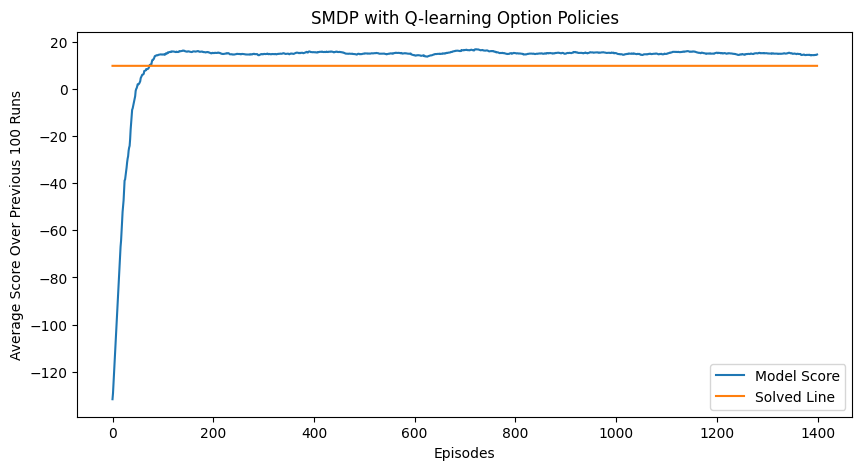

In [30]:
plt.figure(figsize=(10, 5))
avg_rewards_over_100 = [np.average(rewards2[i:i + 100]) for i in range(len(rewards2) - 100)]
plt.plot(avg_rewards_over_100, label='Model Score')
plt.plot([9.7 for _ in range(len(avg_rewards_over_100))], label='Solved Line')
plt.xlabel('Episodes')
plt.ylabel('Average Score Over Previous 100 Runs')
plt.title('SMDP with Q-learning Option Policies')
plt.legend()
plt.show()

In [31]:
state = env.reset()    
done = False
tot_rew = 0
T = 1
# While episode is not over
while not done:
    
    # Choose action        
    x,y,pas,drop = env.decode(state) 
    subState = nDrop*pas+drop
    option = egreedy_policy(q_values_SMDP, subState, epsilon=eps_main)
    eps_main = max(eps_min,eps_decay*eps_main)
    reward_bar = 0
    optdone = False
    move = 0
    prev = state  
    while (optdone == False) and not done:
        

        #--
        #Go to location and drop/pick
        x,y,pas,drop = env.decode(state)
        optdone = False
        while not optdone and not done:
          # optact = policyOpt[drop][x,y]
          # state, reward, done,_ = env.step(optact)
          # tot_rew += reward
          # x,y,pas,drop = env.decode(state)
          # if x == goal[drop][0] and y==goal[drop][1]:
          #   findDrop = True
          optact,optdone = Option(env,state,Qopt,option,eps[option])
          
          [x,y,_,_]=  list(env.decode(state))  

          next_state, reward, done,_ = env.step(optact)

          clear_output(wait=True)
          print(env.render())  
          time.sleep(T)
          
          [x1,y1,_,_]=  list(env.decode(next_state)) 

          tot_rew+=reward

          eps[option] = max(eps_min,eps_decay*eps[option])
          tot_rew+=reward
          reward_surr = reward
          if optdone:
            reward_surr = 20
          if optact<4:  
            Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])
          state = next_state

        #--

    _,_,pas,drop = env.decode(state) 
    subState = nDrop*pas+drop

    _,_,pas,drop = env.decode(prev) 
    subPrev = nDrop*pas+drop
    
    q_values_SMDP[subPrev, option] += alpha*(reward_bar + (gamma**move)*np.max(q_values_SMDP[subState, :]) - q_values_SMDP[subPrev, option])
    updates_SMDP[subPrev, option] += 1
x,y,pas,drop = env.decode(state)


+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
None


Text(0.5, 1.0, 'Policy learnt by SMDP')

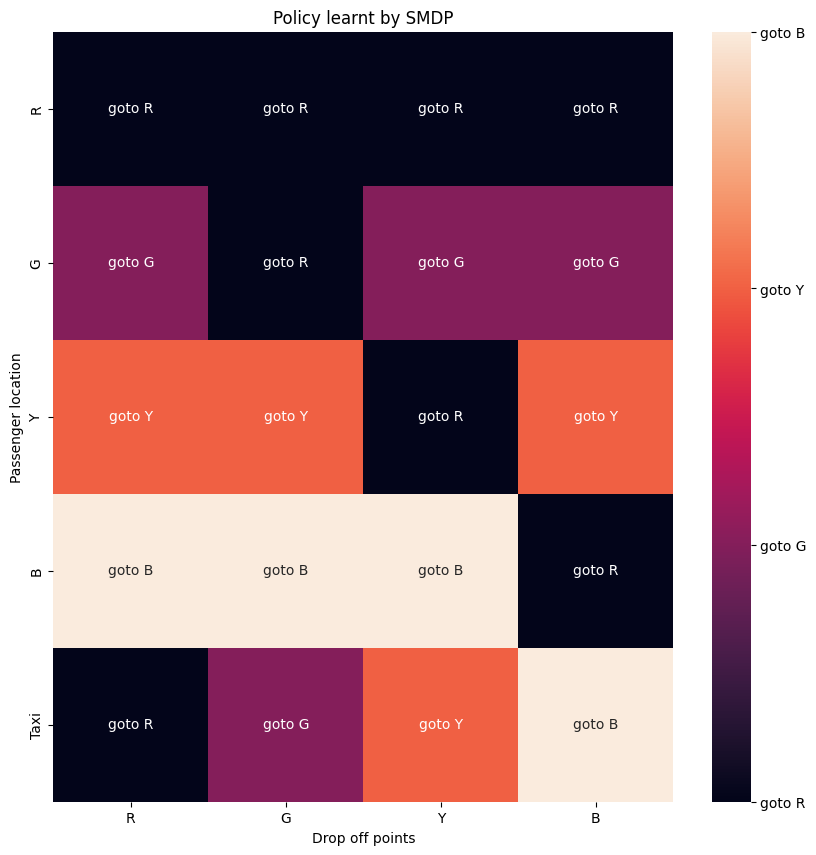

In [32]:
Qmax_SMDP = np.argmax(q_values_SMDP,axis = 1).reshape(5,4)
labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
annot_text = np.vectorize(labels.get)(Qmax_SMDP)
figure, axis = plt.subplots(1, 1,figsize=(10,10))
ax = sns.heatmap(Qmax_SMDP,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annot_text,fmt = '')
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([0, 1, 2, 3])
c_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])

axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Policy learnt by SMDP')

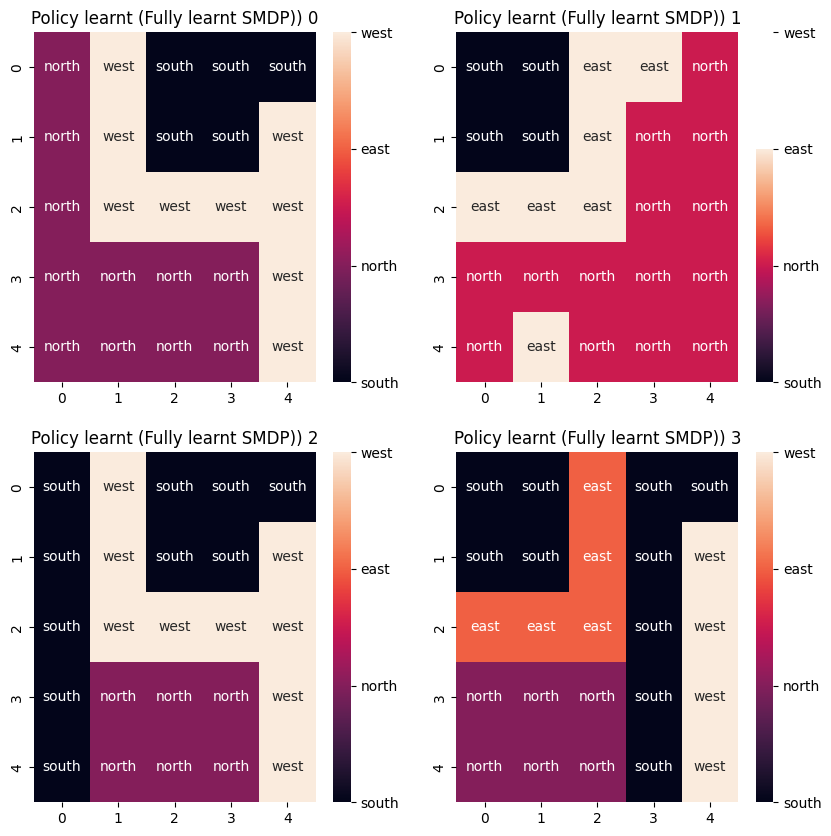

In [33]:
figure, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
  for j in range(2):
    labels = {0:'south',1:'north', 2:'east', 3:'west'}
    annot_text = np.vectorize(labels.get)(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5))
    ax = sns.heatmap(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='')
    axis[i,j].set_title("Policy learnt (Fully learnt SMDP)) {}".format(i*2+j))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south','north','east','west'])
   

## Intra Option Q Learning

In [34]:
def Sub(state, nPas = nPas, nDrop = nDrop):
  _,_,pas,drop = env.decode(state) 
  subState = nDrop*pas+drop 
  return subState 

In [35]:
#### Intra Option Q-Learning

rewards3 = []
T = 1
goal = {0:[0,0],1:[0,4],2:[4,0],3:[4,3]}



# Add parameters you might need here
gamma = 0.9
alpha = 0.1

#Q-Table: (States x Actions) === (env.ns(48) x total actions(6))
nX = 5; nY = 5; nPas = 5; nDrop = 4
q_values_IOQL = np.zeros((nPas*nDrop,nO))
updates_IOQL = np.zeros((nPas*nDrop,nO))

Qopt = {i:np.zeros((env.nS//20,env.nA-2)) for i in range(nO)} #Q-values for each option


eps = {i:0.01 for i in range(nO)}
eps_min = 0.01
eps_decay = 0.99
eps_main = 0.5

count = 0
Neps = 1500

# Iterate over Neps episodes
for i in range(Neps):
    state = env.reset()    
    done = False
    tot_rew=0

    # While episode is not over
    while not done:
        
        # Choose action  
        _,_,pas,drop = env.decode(state) 
        subState = nDrop*pas+drop      
        action = egreedy_policy(q_values_IOQL, subState, epsilon=eps_main)
        eps_main = max(eps_min,eps_main*eps_decay)
        

        option = action
        optdone = False
        prev = state  
        while not optdone and not done:
            
            # Think about what this function might do?
            optact,optdone = Option(env,state,Qopt,option,eps[option])
            next_state, reward, done,_ = env.step(optact)
            
            tot_rew+=reward

            
            #Option Policy Learning
            [x,y,_,_]=  list(env.decode(state)) 
            [x1,y1,_,_]=  list(env.decode(next_state)) 

            

            eps[option] = max(eps_min,eps_decay*eps[option])
            tot_rew+=reward
            reward_surr = reward
            if optdone:
              reward_surr = 20
            if optact<4:  
              Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])



            #finding all options giving same action call
            
            for o in range(nO):
              optact_o,optdone_o = Option(env,state,Qopt,o,eps[o])
              if optact_o == optact:
                eps[o] = max(eps_min,eps_decay*eps[o])
                if optdone_o:
                  q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*np.max(q_values_IOQL[Sub(next_state), :]) - q_values_IOQL[Sub(state), o])
                else:
                  q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*q_values_IOQL[Sub(next_state), o] - q_values_IOQL[Sub(state), o]) 

                updates_IOQL[Sub(state), o] += 1
            state = next_state 
        
    rewards3.append(tot_rew)
    x,y,pas,drop = env.decode(state)
    if pas==drop:
      count+=1
      clear_output(wait=True)
      print('Success ({}/{}) = {}%'.format(count,i+1,100*count/(i+1)))
 
        

Success (1485/1500) = 99.0%


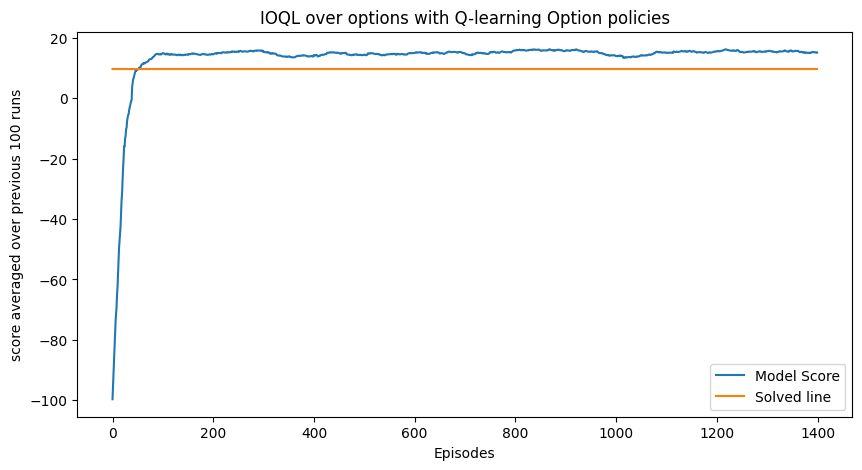

In [36]:
plt.figure(figsize = (10,5))
avg_rews3 = [np.average(rewards3[i:i+100]) for i in range(len(rewards3)-100)]
plt.plot(avg_rews3,label = 'Model Score')
plt.plot([9.7 for i in range(len(avg_rews3))],label = 'Solved line')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.title('IOQL over options with Q-learning Option policies')
plt.legend()

In [37]:
state = env.reset()    
done = False
tot_rew=0

# While episode is not over
while not done:
    
    # Choose action  
    _,_,pas,drop = env.decode(state) 
    subState = nDrop*pas+drop      
    action = egreedy_policy(q_values_IOQL, subState, epsilon=eps_main)
    eps_main = max(eps_min,eps_main*eps_decay)
    

    option = action
    optdone = False
    prev = state  
    while not optdone and not done:
        
        # Think about what this function might do?
        optact,optdone = Option(env,state,Qopt,option,eps[option])
        next_state, reward, done,_ = env.step(optact)
        clear_output(wait=True)
        print(env.render())  
        time.sleep(T)
        
        tot_rew+=reward

        
        #Option Policy Learning
        [x,y,_,_]=  list(env.decode(state)) 
        [x1,y1,_,_]=  list(env.decode(next_state)) 

        

        eps[option] = max(eps_min,eps_decay*eps[option])
        tot_rew+=reward
        reward_surr = reward
        if optdone:
          reward_surr = 20
        if optact<4:  
          Qopt[option][5*x+y, optact] = Qopt[option][5*x+y, optact] + alpha*(reward_surr + gamma*np.max(Qopt[option][5*x1+y1, :]) - Qopt[option][5*x+y, optact])


        _ ,optdone_next = Option(env,state,Qopt,option,eps[option]) 

        #finding all options giving same action call
        
        for o in range(nO):
          optact_o,optdone_o = Option(env,state,Qopt,o,eps[o])
          if optact_o == optact:
            eps[o] = max(eps_min,eps_decay*eps[o])
            if optdone_o:
              q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*np.max(q_values_IOQL[Sub(next_state), :]) - q_values_IOQL[Sub(state), o])
            else:
              q_values_IOQL[Sub(state), o] += alpha*(reward + gamma*q_values_IOQL[Sub(next_state), o] - q_values_IOQL[Sub(state), o]) 

            updates_IOQL[Sub(state), o] += 1
        state = next_state 
    
rewards3.append(tot_rew)
x,y,pas,drop = env.decode(state)

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Dropoff)
None


Text(0.5, 1.0, 'Policy over default actions learnt by Intra Options')

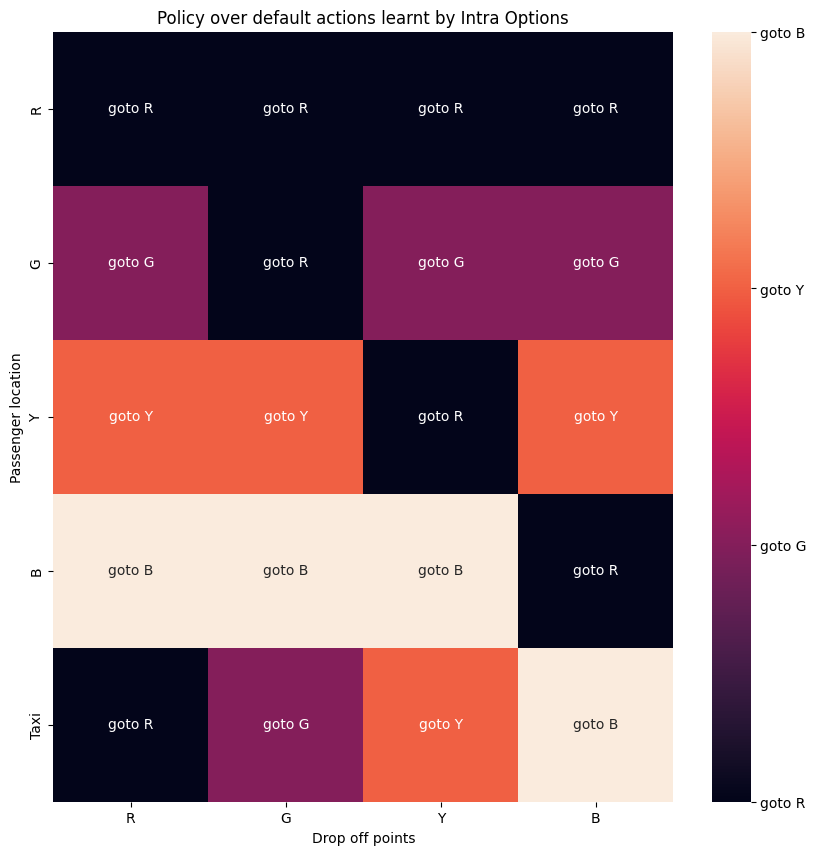

In [45]:
Qmax_IOQL = np.argmax(q_values_IOQL,axis = 1).reshape(5,4)
labels = {0:'goto R',1:'goto G', 2:'goto Y', 3:'goto B'}
annot_text = np.vectorize(labels.get)(Qmax_IOQL)

figure, axis = plt.subplots(1, 1,figsize=(10,10))
ax = sns.heatmap(Qmax_IOQL,ax=axis,xticklabels = ["R","G","Y","B"],yticklabels = ['R','G','Y','B','Taxi'],annot = annot_text, fmt = '')
c_bar = ax.collections[0].colorbar
c_bar.set_ticks([i for i in range(4)])

c_bar.set_ticklabels(['goto R','goto G', 'goto Y', 'goto B'])
#c_bar.set_ticklabels(['south','north','east','west','pick up','drop'])
axis.set_xlabel('Drop off points')
axis.set_ylabel("Passenger location")
axis.set_title('Policy over options learnt by Intra Options')

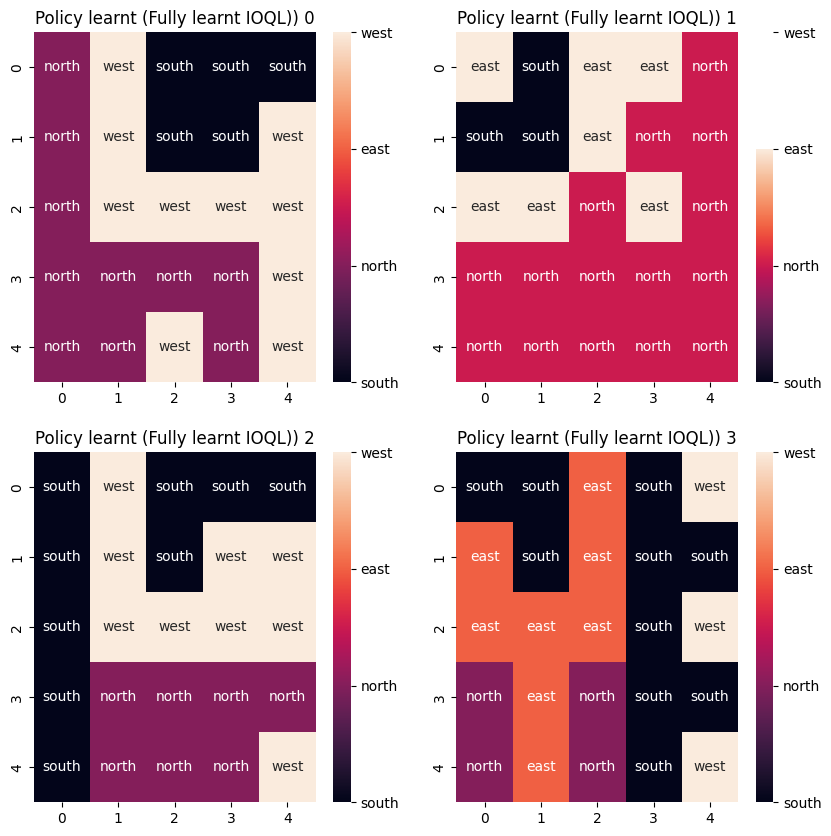

In [42]:
figure, axis = plt.subplots(2,2,figsize=(10,10))
for i in range(2):
  for j in range(2):
    labels = {0:'south',1:'north', 2:'east', 3:'west'}
    annot_text = np.vectorize(labels.get)(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5))
    ax = sns.heatmap(np.argmax(Qopt[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='')
    axis[i,j].set_title("Policy learnt (Fully learnt IOQL)) {}".format(i*2+j))
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['south','north','east','west'])
   